In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [2]:
parameters = {'kernel':['rbf'],
              'C':[0.05 ,0.5, 1, 5, 10, 50, 100, 500, 1000],
              'epsilon':[0.1,0.01,0.001, 0.0001]}

In [3]:
def GridSearch(rf, X_train, X_test, y_train, y_test, grid, verbose=False, skip=False):
    best_score = -10
    par = ParameterGrid(grid)
    ln = len(par)
    i = 0
    for g in par:
        if skip and i == 46:
            continue
        if(verbose):
            print(f"Probando: {g}, {i} de {ln}")
        i+=1
        rf.set_params(**g)
        startTime = time.time()
        rf.fit(X_train, np.ravel(y_train))
        elapsedTime = time.time() - startTime
        score = rf.score(X_test, y_test)
        if(verbose):
            print(f"Tiempo de entrenamiento: {elapsedTime} s, score: {score}")
        # save if best
        if score > best_score:
            best_score = score
            best_grid = g
    print(f"Best Score: {best_score}")
    print(f"Best Parameters: {best_grid}")
    return best_grid

In [4]:
df = pd.read_parquet("dataset.parquet")
df.COU.unique()

array(['AUS', 'AUT', 'BEL', 'CAN', 'CZE', 'DNK', 'FIN', 'FRA', 'DEU',
       'GRC', 'HUN', 'ISL', 'IRL', 'ITA', 'JPN', 'KOR', 'LUX', 'MEX',
       'NLD', 'NZL', 'NOR', 'POL', 'PRT', 'SVK', 'ESP', 'SWE', 'CHE',
       'TUR', 'GBR', 'USA', 'BRA', 'CHL', 'CHN', 'EST', 'IDN', 'ISR',
       'RUS', 'SVN', 'COL', 'LVA', 'CRI', 'IND', 'LTU'], dtype=object)

In [59]:
Year_to_separate = 2010
df = pd.read_parquet("dataset.parquet")
country = 'BEL'
df = df[df.COU == country]
Y = df[['Municipal', 'Year']]
X = df[[x for x in df.columns if x not in ['Country', 'COU', 'Municipal', 'Household', 'Recovered', 'Recicled', 'Compost', 'Disposal']]]
X_train = X[X.Year < Year_to_separate].copy()
X_test = X[X.Year >= Year_to_separate].copy()
Y_train = Y[X.Year < Year_to_separate].copy()
Y_test = Y[X.Year >= Year_to_separate].copy()
#X_train = pd.read_parquet("Xtime/X_train.parquet")
#X_test = pd.read_parquet("Xtime/X_test.parquet")
#Y_train = pd.read_parquet("Ytime/Y_train.parquet")
#Y_test = pd.read_parquet("Ytime/Y_test.parquet")
X_train.drop(columns={'Year'}, inplace=True)
X_test.drop(columns={'Year'}, inplace=True)
scalerX = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scalerX.transform(X_train))
X_test = pd.DataFrame(scalerX.transform(X_test))
scalerY = MinMaxScaler().fit(Y_train)
Y_train = pd.DataFrame(scalerY.transform(Y_train))
Y_test = pd.DataFrame(scalerY.transform(Y_test))
Y_train = Y_train[[Y_train.columns[0]]]
Y_test = Y_test[[Y_test.columns[0]]]

In [60]:
g = GridSearch(svm.SVR(), X_train, X_test, Y_train, Y_test, parameters, verbose=True)
clf1 = svm.SVR(**g).fit(X_train, np.ravel(Y_train))

Probando: {'C': 0.05, 'epsilon': 0.1, 'kernel': 'rbf'}, 0 de 36
Tiempo de entrenamiento: 0.0022461414337158203 s, score: 0.5590148253730006
Probando: {'C': 0.05, 'epsilon': 0.01, 'kernel': 'rbf'}, 1 de 36
Tiempo de entrenamiento: 0.0018339157104492188 s, score: 0.1054694273888972
Probando: {'C': 0.05, 'epsilon': 0.001, 'kernel': 'rbf'}, 2 de 36
Tiempo de entrenamiento: 0.0021545886993408203 s, score: 0.1798154492529479
Probando: {'C': 0.05, 'epsilon': 0.0001, 'kernel': 'rbf'}, 3 de 36
Tiempo de entrenamiento: 0.002833843231201172 s, score: 0.18727574511247858
Probando: {'C': 0.5, 'epsilon': 0.1, 'kernel': 'rbf'}, 4 de 36
Tiempo de entrenamiento: 0.0025513172149658203 s, score: 0.7406316318458062
Probando: {'C': 0.5, 'epsilon': 0.01, 'kernel': 'rbf'}, 5 de 36
Tiempo de entrenamiento: 0.001817941665649414 s, score: 0.5860617535857722
Probando: {'C': 0.5, 'epsilon': 0.001, 'kernel': 'rbf'}, 6 de 36
Tiempo de entrenamiento: 0.0023186206817626953 s, score: 0.5598854049435606
Probando: {'C':

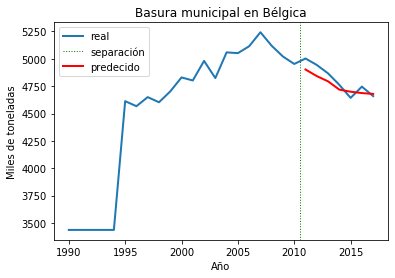

1.3575143221663504


In [62]:
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en Bélgica")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).mean() * 100)
deu2000 = predictions

In [37]:
Year_to_separate = 2010
df = pd.read_parquet("dataset.parquet")
country = 'USA'
df = df[df.COU == country]
Y = df[['Municipal', 'Year']]
X = df[[x for x in df.columns if x not in ['Country', 'COU', 'Municipal', 'Household', 'Recovered', 'Recicled', 'Compost', 'Disposal']]]
X_train = X[X.Year < Year_to_separate].copy()
X_test = X[X.Year >= Year_to_separate].copy()
Y_train = Y[X.Year < Year_to_separate].copy()
Y_test = Y[X.Year >= Year_to_separate].copy()
#X_train = pd.read_parquet("Xtime/X_train.parquet")
#X_test = pd.read_parquet("Xtime/X_test.parquet")
#Y_train = pd.read_parquet("Ytime/Y_train.parquet")
#Y_test = pd.read_parquet("Ytime/Y_test.parquet")
X_train.drop(columns={'Year'}, inplace=True)
X_test.drop(columns={'Year'}, inplace=True)
scalerX = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scalerX.transform(X_train))
X_test = pd.DataFrame(scalerX.transform(X_test))
scalerY = MinMaxScaler().fit(Y_train)
Y_train = pd.DataFrame(scalerY.transform(Y_train))
Y_test = pd.DataFrame(scalerY.transform(Y_test))
Y_train = Y_train[[Y_train.columns[0]]]
Y_test = Y_test[[Y_test.columns[0]]]

In [9]:
g = GridSearch(svm.SVR(), X_train, X_test, Y_train, Y_test, parameters, verbose=True)
clf1 = svm.SVR(**g).fit(X_train, np.ravel(Y_train))

Probando: {'C': 0.05, 'epsilon': 0.1, 'kernel': 'rbf'}, 0 de 36
Tiempo de entrenamiento: 0.002120494842529297 s, score: -7.742709419932504
Probando: {'C': 0.05, 'epsilon': 0.01, 'kernel': 'rbf'}, 1 de 36
Tiempo de entrenamiento: 0.0018358230590820312 s, score: -9.33921576496823
Probando: {'C': 0.05, 'epsilon': 0.001, 'kernel': 'rbf'}, 2 de 36
Tiempo de entrenamiento: 0.0038318634033203125 s, score: -9.729980011312223
Probando: {'C': 0.05, 'epsilon': 0.0001, 'kernel': 'rbf'}, 3 de 36
Tiempo de entrenamiento: 0.0016531944274902344 s, score: -9.771900064000125
Probando: {'C': 0.5, 'epsilon': 0.1, 'kernel': 'rbf'}, 4 de 36
Tiempo de entrenamiento: 0.0020983219146728516 s, score: -8.109110168346204
Probando: {'C': 0.5, 'epsilon': 0.01, 'kernel': 'rbf'}, 5 de 36
Tiempo de entrenamiento: 0.001954793930053711 s, score: -6.678008462489594
Probando: {'C': 0.5, 'epsilon': 0.001, 'kernel': 'rbf'}, 6 de 36
Tiempo de entrenamiento: 0.00170135498046875 s, score: -6.371983823789559
Probando: {'C': 0.5

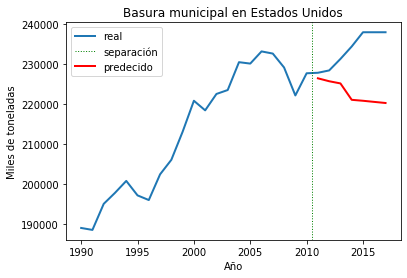

4.908923060741547


In [10]:
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en Estados Unidos")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).mean() * 100)
deu2000 = predictions